In [1]:
import pandas as pd
from collections import Counter
from uszipcode import SearchEngine
from datetime import datetime
import numpy as np
import random
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import csv
import scipy.stats
import os
import seaborn as sns
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.model_selection import StratifiedKFold,cross_val_score,GridSearchCV
from sklearn.feature_selection import RFECV
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import auc,roc_curve,confusion_matrix,classification_report
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
engine = SearchEngine()

/Users/cullen/opt/anaconda3/lib/python3.8/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


### Import data Part

#### Data from Santarosa, mostly from western of united states

In [2]:
from sklearn.model_selection import train_test_split

In [3]:
santarosa=pd.read_csv('Animal_Shelter_Intake_and_Outcome.csv')

In [4]:
santarosa=santarosa.loc[:,['Type', 'Breed', 'Color', 'Sex', 'Size', 'Date Of Birth','Intake Date',
       'Outcome Date', 'Days in Shelter', 'Intake Type', 'Intake Subtype',
       'Outcome Type', 'Outcome Subtype', 'Intake Condition','Outcome Zip Code']]
santarosa=santarosa.loc[santarosa.Type=='DOG']
santarosa=santarosa.reset_index(drop=True)
santarosa=santarosa.rename(columns={'Outcome Zip Code':'zipcode','Date Of Birth':'DOB','Intake Date':'IntakeDate',
       'Outcome Date':'OutcomeDate', 'Days in Shelter':'DaysinShelter', 'Intake Type':'IntakeType', 'Intake Subtype':'IntakeSubtype',
       'Outcome Type':'OutcomeType', 'Outcome Subtype':'OutcomeSubtype', 'Intake Condition':'IntakeCondition'})

for i in range (len(santarosa)):
    try:
        zipcode = engine.by_zipcode(int(santarosa.loc[i,'zipcode']))
        santarosa.loc[i,'County']=zipcode.county
    except:
        pass
santarosa=santarosa.drop(columns=['zipcode'])

In [5]:
county=dict(Counter(santarosa[santarosa['County'].notna()].County))
county_lst=[]
for k,v in county.items():
    if v>20:
        county_lst.append(k)

In [6]:
for i in range(len(santarosa)):
    if santarosa.loc[i,'County'] not in county_lst:
        santarosa=santarosa.drop(i)
santarosa=santarosa.reset_index(drop=True)

In [7]:
print('santarosa',santarosa.shape)

santarosa (10978, 15)


In [8]:
from collections import Counter

#### check missing value and remove

In [9]:
Counter(santarosa["Size"].isna())

Counter({False: 10951, True: 27})

In [10]:
Counter(santarosa["Size"])

Counter({'MED': 3240,
         'LARGE': 3124,
         'SMALL': 2759,
         'PUPPY': 710,
         'TOY': 959,
         'X-LRG': 159,
         nan: 27})

In [11]:
santarosa = santarosa[santarosa['Size'].notna()]

In [12]:
len(santarosa)

10951

In [13]:
Counter(santarosa["OutcomeType"])

Counter({'TRANSFER': 1625,
         'ADOPTION': 2922,
         'RETURN TO OWNER': 5943,
         'EUTHANIZE': 381,
         'DIED': 5,
         'RTOS': 28,
         nan: 28,
         'APPT': 3,
         'DISPOSAL': 14,
         'ESCAPED/STOLEN': 2})

In [14]:
color_label = [None]*len(santarosa)
for i in range(len(santarosa)):
    if ("BLACK" not in santarosa["Color"].iloc[i]): #color is not black
        color_label[i] = 0
    if ("BLACK" in santarosa["Color"].iloc[i] and santarosa["Color"].iloc[i]!="BLACK"): #contain black color but not black
        color_label[i] = 1
    if (santarosa["Color"].iloc[i] == "BLACK"):#black color
        color_label[i] = 2

In [15]:
#santarosa

In [16]:
santarosa = santarosa[santarosa['Size'].notna()]
santarosa = santarosa[santarosa['OutcomeType'].notna()]
santarosa = santarosa[santarosa['Sex'].notna()]
santarosa = santarosa[santarosa['Color'].notna()]
santarosa = santarosa[santarosa['Breed'].notna()]
santarosa = santarosa[santarosa['DaysinShelter'].notna()]
santarosa=santarosa.reset_index(drop=True)

In [17]:
Counter(santarosa['County'])

Counter({'Sonoma County': 9456,
         'Contra Costa County': 218,
         'Marin County': 155,
         'Mendocino County': 145,
         'Lake County': 132,
         'San Francisco County': 254,
         'Sacramento County': 48,
         'Santa Clara County': 67,
         'Napa County': 106,
         'San Mateo County': 23,
         'Alameda County': 97,
         'Ada County': 37,
         'Humboldt County': 43,
         'Placer County': 46,
         'Solano County': 49,
         'Nevada County': 21,
         'Los Angeles County': 26})

In [18]:
county_label=dict()
i=0
for k in county_lst:
    county_label[k]=i
    i=i+1

In [19]:
county_label

{'Sonoma County': 0,
 'Contra Costa County': 1,
 'Marin County': 2,
 'Mendocino County': 3,
 'Lake County': 4,
 'San Francisco County': 5,
 'Sacramento County': 6,
 'Santa Clara County': 7,
 'Napa County': 8,
 'San Mateo County': 9,
 'Alameda County': 10,
 'Ada County': 11,
 'Humboldt County': 12,
 'Placer County': 13,
 'Solano County': 14,
 'Nevada County': 15,
 'Los Angeles County': 16}

In [20]:
for i in range(len(santarosa)):
    santarosa.loc[i,'Location_label']=county_label[santarosa.loc[i,'County']]

#### Data from louisvilleky, most from eastern part of united states. Do the same data cleaning process

In [21]:
louisvilleky=pd.read_csv('Animal_IO_Data_louisvilleky.csv')

In [22]:
louisvilleky=louisvilleky.loc[:,['jurisdiction', 'intype', 'insubtype', 'indate',
        'outtype', 'outsubtype', 'outdate', 'animaltype', 'sex',
        'petsize', 'color', 'breed']]
louisvilleky=louisvilleky.loc[louisvilleky.animaltype=='DOG']
louisvilleky=louisvilleky.reset_index(drop=True)
louisvilleky=louisvilleky.rename(columns={'animaltype':'Type',
                                          'jurisdiction':'zipcode',
                                          'intype':'IntakeType', 
                                          'insubtype':'IntakeSubtype',
                                          'indate':'IntakeDate',
                                          'outtype':'OutcomeType', 
                                          'outsubtype':'OutcomeSubtype',
                                          'outdate':'OutcomeDate',
                                          'sex':'Sex',
                                          'petsize':'Size',
                                          'color':'Color', 
                                          'breed':'Breed'})
date_format = "%Y-%m-%d"
for i in range(len(louisvilleky)):
    try:
        a = datetime.strptime(louisvilleky.loc[i,'OutcomeDate'][:10], date_format)
        b = datetime.strptime(louisvilleky.loc[i,'IntakeDate'][:10], date_format)
        louisvilleky.loc[i,'DaysinShelter']=(a-b).days
    except:
        pass
for i in range (len(louisvilleky)):
    try:
        zipcode = engine.by_zipcode(int(louisvilleky.loc[i,'zipcode']))
        louisvilleky.loc[i,'County']=zipcode.county
    except:
        pass
louisvilleky=louisvilleky.drop(columns=['zipcode'])

In [23]:
louisvilleky = louisvilleky[louisvilleky['Size'].notna()]

louisvilleky = louisvilleky[louisvilleky['OutcomeType'].notna()]

louisvilleky = louisvilleky[louisvilleky['Sex'].notna()]

louisvilleky = louisvilleky[louisvilleky['Color'].notna()]

louisvilleky = louisvilleky[louisvilleky['Breed'].notna()]

louisvilleky = louisvilleky[louisvilleky['DaysinShelter'].notna()]

In [24]:
louisvilleky=louisvilleky.sort_values(by='IntakeDate',ascending=False).reset_index(drop=True)[0:15000]

In [25]:
location_label = [17]*len(louisvilleky)
county_label[louisvilleky.loc[0,'County']]=17

In [26]:
louisvilleky["Location_label"] = location_label

### Combine two dataframe

In [28]:
final_data=pd.concat([santarosa,louisvilleky])


In [29]:
Counter(louisvilleky.Size)

Counter({'LARGE': 4814,
         'PUPPY': 1549,
         'MED': 5222,
         'SMALL': 2597,
         'X-LRG': 271,
         'TOY': 547})

### Label encoding part

#### intake subtype

In [30]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(['STRAY', 'ADOPTION RETURN', 'OWNER SURRENDER', 'CONFISCATE', 'TRANSFER', 'QUARANTINE', 'OS APPT', 'DISPOSAL', 'RETURN', 'FOSTER', 'OWNER SUR', 'FOUND', 'LOST', 'FOR TRANSP', 'EVACUEE'])
intake_type_label = le.transform(final_data["IntakeType"])
final_data.loc[:,'IntakeTypeLabel']=intake_type_label

In [31]:
final_data=final_data[final_data['IntakeSubtype'].notna()]

In [32]:
subtype=dict(Counter(final_data['IntakeSubtype']))

In [33]:
le = preprocessing.LabelEncoder()
le.fit(list(subtype.keys()))
subtype_label = le.transform(final_data["IntakeSubtype"])
final_data.loc[:,'IntakeSubtypeLabel']=subtype_label

### Sex label

In [34]:
final_data=final_data.loc[(final_data.Sex!='Unknown')]
final_data=final_data.loc[final_data.Sex!='U'].reset_index(drop=True)

In [35]:
#sex encoding to label
sex_label = [None]*len(final_data)
for i in range(len(final_data)):
    if (final_data["Sex"].iloc[i] in ["Male","M"]): #sex is male
        sex_label[i] = 0
    if (final_data["Sex"].iloc[i] in ["Female","F"]): #female
        sex_label[i] = 1
    if (final_data["Sex"].iloc[i] in ["Spayed","S"]):#spayed
        sex_label[i] = 2
    if (final_data["Sex"].iloc[i] in ["Neutered","N"]):#Neutered
        sex_label[i] = 3


### Color label

In [36]:
color_label = [None]*len(final_data)
for i in range(len(final_data)):
    if ("BLACK" not in final_data["Color"].iloc[i]): #color is not black
        color_label[i] = 0
    if ("BLACK" in final_data["Color"].iloc[i] and final_data["Color"].iloc[i]!="BLACK"): #contain black color but not black
        color_label[i] = 1
    if (final_data["Color"].iloc[i] == "BLACK"):#black color
        color_label[i] = 1

### Size label

In [37]:
size_label = [None]*len(final_data)
for i in range(len(final_data)):
    if(final_data["Size"].iloc[i] in ["SMALL","TOY","PUPPY"]):
        size_label[i] = 0
    if(final_data["Size"].iloc[i] in ["MED",'67.5']):
        size_label[i] = 1
    if(final_data["Size"].iloc[i] in ["LARGE","X-LRG"]):
        size_label[i] = 2
    if(final_data["Size"].iloc[i] == None):
        size_label[i] = 1

### Breed label

In [38]:
breed_type_lst = list(Counter(final_data["Breed"]).keys())
pure_lst = []
for i in range(len(breed_type_lst)):
    if ("/" not in breed_type_lst[i] and "MIX" not in breed_type_lst[i] and "&" not in breed_type_lst[i] and "," not in breed_type_lst[i]):
        pure_lst.append(breed_type_lst[i])
pure_lst

['GERM SHEPHERD',
 'PIT BULL',
 'CHIHUAHUA SH',
 'AMERICAN STAFF',
 'BOXER',
 'ITAL GREYHOUND',
 'PARSON RUSS TER',
 'DACHSHUND',
 'ALASK MALAMUTE',
 'SIBERIAN HUSKY',
 'BORDER COLLIE',
 'DOBERMAN PINSCH',
 'CAIRN TERRIER',
 'ENG COONHOUND',
 'ENG BULLDOG',
 'MASTIFF',
 'MALTESE',
 'BOSTON TERRIER',
 'FOX TERR SMOOTH',
 'POMERANIAN',
 'POODLE MIN',
 'AMER FOXHOUND',
 'AMER BULLDOG',
 'MIN PINSCHER',
 'GREAT PYRENEES',
 'CHIHUAHUA LH',
 'AUST CATTLE DOG',
 'BEAGLE',
 'YORKSHIRE TERR',
 'ALASKAN HUSKY',
 'LABRADOR RETR',
 'ROTTWEILER',
 'BELG MALINOIS',
 'BULLDOG',
 'ENG FOXHOUND',
 'RAT TERRIER',
 'POODLE TOY',
 'BULLMASTIFF',
 'AUST SHEPHERD',
 'ANATOL SHEPHERD',
 'CATAHOULA',
 'FOX TERR WIRE',
 'AKBASH',
 'FRENCH BULLDOG',
 'AKITA',
 'TOY FOX TERRIER',
 'CHOW CHOW',
 'AM PIT BULL TER',
 'AMER ESKIMO',
 'COCKER SPAN',
 'PLOTT HOUND',
 'SHIH TZU',
 'GREAT DANE',
 'PUG',
 'BLUETICK HOUND',
 'LHASA APSO',
 'TIBETAN TERR',
 'WELSH CORGI CAR',
 'ENG POINTER',
 'ST BERNARD SMTH',
 'GERM WH P

In [39]:
Counter(final_data["Breed"]).most_common

<bound method Counter.most_common of Counter({'PIT BULL': 4234, 'CHIHUAHUA SH': 1369, 'GERM SHEPHERD': 1222, 'LABRADOR RETR': 1029, 'PIT BULL / MIX': 886, 'LABRADOR RETR / MIX': 708, 'PIT BULL/MIX': 622, 'SIBERIAN HUSKY': 489, 'CHIHUAHUA SH/MIX': 439, 'BEAGLE': 429, 'SHIH TZU': 381, 'GERM SHEPHERD / MIX': 317, 'LABRADOR RETR/MIX': 289, 'ROTTWEILER': 287, 'GERM SHEPHERD/MIX': 283, 'BOXER / MIX': 248, 'BOXER': 244, 'BEAGLE / MIX': 244, 'YORKSHIRE TERR': 221, 'ALASKAN HUSKY': 221, 'PARSON RUSS TER/MIX': 187, 'BORDER COLLIE': 186, 'POODLE MIN': 179, 'CANE CORSO': 154, 'CHIHUAHUA SH / MIX': 148, 'CHIHUAHUA LH': 147, 'BORDER COLLIE/MIX': 144, 'AUST CATTLE DOG': 134, 'PARSON RUSS TER': 125, 'AUST SHEPHERD': 125, 'POMERANIAN': 120, 'MIN PINSCHER': 117, 'GREAT PYRENEES': 117, 'AMER BULLDOG': 112, 'JACK RUSS TER / MIX': 110, 'BORDER COLLIE / MIX': 110, 'CAIRN TERRIER/MIX': 106, 'JACK RUSS TER': 104, 'AM PIT BULL TER': 101, 'AMERICAN STAFF': 99, 'GOLDEN RETR': 97, 'DACHSHUND': 96, 'POODLE MIN/MIX

In [40]:
#Top 10 breed type in data:
top_10_breed = ["BULL","CHIHUAHUA","GERM SHEPHERD","LABRADOR","HUSKY","BEAGLE","PARSON RUSS","BORDER COLLIE","ROTTWEILER","BOXER"]
breed_label = [None]*len(final_data)
for i in range(len(final_data)):
    for j in range(len(top_10_breed)):
        if("/" in final_data["Breed"].iloc[i] and "/MIX" not in final_data["Breed"].iloc[i]): #Mix type
            breed_label[i] = 0
        if(top_10_breed[j] in final_data["Breed"].iloc[i] and "/" not in final_data["Breed"].iloc[i] and "&" not in final_data["Breed"] and "," not in final_data["Breed"]): #top_10_pure type dog
            breed_label[i] = j+1
        if(top_10_breed[j] in final_data["Breed"].iloc[i] and "/MIX" in final_data["Breed"].iloc[i]): #top_10_mix type dog
            breed_label[i] = j+1
breed_label = [11 if x == None else x for x in breed_label] #all other pure types of dogs 
Counter(breed_label)

Counter({1: 5307,
         11: 5419,
         3: 1505,
         2: 2020,
         0: 7736,
         8: 332,
         7: 312,
         5: 787,
         10: 269,
         4: 1318,
         9: 323,
         6: 470})

### Outcome Type label

In [41]:
Counter(final_data["OutcomeType"])

Counter({'TRANSFER': 3074,
         'ADOPTION': 8016,
         'RETURN TO OWNER': 5914,
         'EUTHANIZE': 378,
         'DIED': 48,
         'RTOS': 28,
         'APPT': 3,
         'DISPOSAL': 425,
         'ESCAPED/STOLEN': 2,
         'RTO': 3603,
         'EUTH': 1053,
         'FOSTER': 1461,
         'TRANSPORT': 457,
         'RELEASE': 3,
         'LOST': 9,
         'TNR': 1,
         'LOST EXP': 885,
         'FOUND EXP': 438})

In [42]:
outcome_label = [None]*len(final_data)
for i in range(len(final_data)):
    if(final_data["OutcomeType"].iloc[i] in ["RETURN TO OWNER","RTOS","RTO","ADOPTION"]):
        outcome_label[i] = 0 #"With Home"
    if(final_data["OutcomeType"].iloc[i] not in ["RETURN TO OWNER","RTOS","RTO","ADOPTION"]):
        outcome_label[i] = 1 #"No Home"

In [43]:
for i in range(len(final_data)):
    if(final_data["OutcomeType"].iloc[i] in [ "ADOPTION",'APPT']):
        final_data.loc[i,'OutcomeType'] = "ADOPTION"
   
    if(final_data["OutcomeType"].iloc[i] in ["RETURN TO OWNER","RTOS","RTO"]):
        final_data.loc[i,'OutcomeType'] = "RETURN TO OWNER"
    if(final_data["OutcomeType"].iloc[i]=='EUTH'):
        final_data.loc[i,'OutcomeType']= 'EUTHANIZE'
    if(final_data["OutcomeType"].iloc[i] in ['TRANSPORT','TNR']):
        final_data.loc[i,'OutcomeType'] ='TRANSFER'
    if(final_data["OutcomeType"].iloc[i]=='LOST EXP'):
        final_data.loc[i,'OutcomeType']= 'LOST'
    

In [44]:
Counter(final_data['OutcomeType'])

Counter({'TRANSFER': 3532,
         'ADOPTION': 8019,
         'RETURN TO OWNER': 9545,
         'EUTHANIZE': 1431,
         'DIED': 48,
         'DISPOSAL': 425,
         'ESCAPED/STOLEN': 2,
         'FOSTER': 1461,
         'RELEASE': 3,
         'LOST': 894,
         'FOUND EXP': 438})

In [49]:
final_data["sex_label"] = sex_label
final_data["color_label"] = color_label
final_data["size_label"] = size_label
final_data["breed_label"] = breed_label
final_data["outcome_label"] = outcome_label

Text(0.5, 1.0, 'Outcome types for Animals')

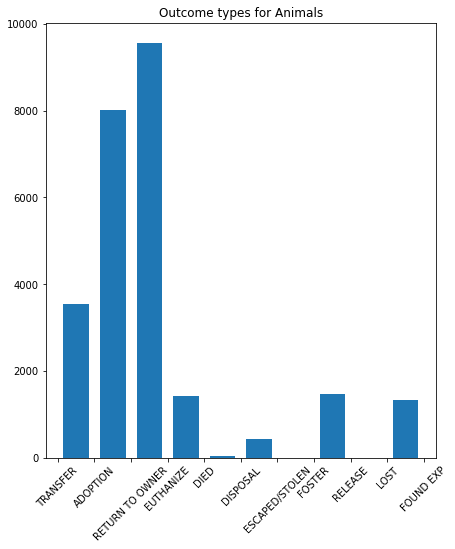

In [50]:
plt.figure(figsize=(7,8))
plt.hist((final_data['OutcomeType']),rwidth=0.7)
plt.xticks(rotation=45)
plt.title('Outcome types for Animals')

In [51]:
for i in range(len(final_data)):
    if(final_data["Sex"].iloc[i] in [ "Male",'M']):
        final_data.loc[i,'Sex'] = "Male"
   
    if(final_data["Sex"].iloc[i] in ["Female",'F']):
        final_data.loc[i,'Sex'] = "Female"
    if(final_data["Sex"].iloc[i] in ["Spayed",'S']):
        final_data.loc[i,'Sex']= 'Spayed'
    if(final_data["Sex"].iloc[i] in ['Neutered','N']):
        final_data.loc[i,'Sex'] ='Neutered'

Text(0.5, 1.0, 'Sex Distribution in Shelter')

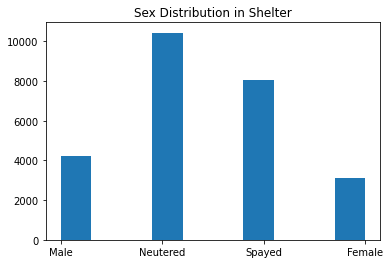

In [52]:
plt.hist(final_data.Sex)
plt.title('Sex Distribution in Shelter')


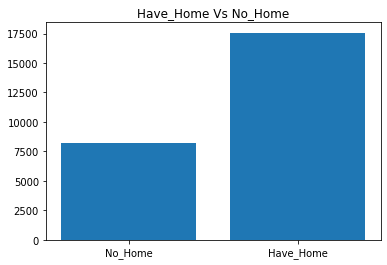

In [53]:
outcome_list=final_data['outcome_label']
outcome_list=outcome_list.replace({1:'No_Home',0:'Have_Home'})

outcome_dict=dict(Counter(final_data['outcome_label']))

outcome=['No_Home','Have_Home']
h=list(outcome_dict.values())
 
#bar plot
plt.bar(outcome, height = h)
plt.title('Have_Home Vs No_Home')
plt.show()

In [54]:
Counter(final_data.loc[final_data.County!='Jefferson County']['color_label'])

Counter({1: 4386, 0: 8070})

In [55]:
a=final_data.loc[:,['size_label','outcome_label']]
Counter(a.loc[a.size_label==0].outcome_label)

Counter({0: 5907, 1: 3135})

In [81]:
Counter(a.loc[a.size_label==1].outcome_label)

Counter({1: 2558, 0: 5863})

In [83]:
Counter(a.loc[a.size_label==2].outcome_label)

Counter({0: 5791, 1: 2544})

### Choose the required variables for training the model

In [56]:
dog_data = final_data[["sex_label","color_label","size_label","breed_label","Location_label",'DaysinShelter','IntakeTypeLabel','IntakeSubtypeLabel',"outcome_label"]]

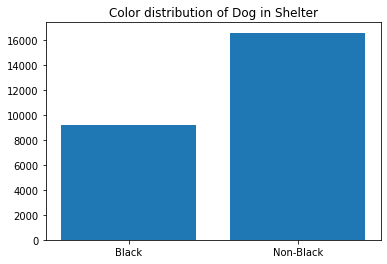

In [57]:
color_list=dog_data['color_label']
color_list=color_list.replace({1:'Black',0:'Non-Black'})

color_dict=dict(Counter(dog_data['color_label']))

color=['Black','Non-Black']
h=list(color_dict.values())
c = ['red',  'blue']
 
#bar plot
plt.bar(color, height = h)
plt.title('Color distribution of Dog in Shelter')
plt.show()

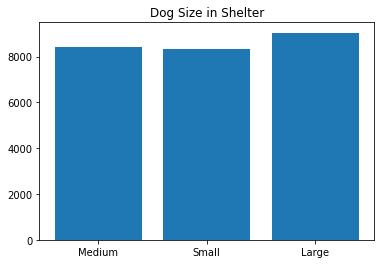

In [58]:
color_list=dog_data['size_label']
color_list=color_list.replace({1:'Medium',0:'Small',2:'Large'})

color_dict=dict(Counter(dog_data['size_label']))

color=['Medium','Small','Large']
h=list(color_dict.values())

 
#bar plot
plt.bar(color, height = h)
plt.title('Dog Size in Shelter')
plt.show()

In [62]:
import random
dog_data=dog_data.reset_index(drop=True)
dog_data=shuffle(dog_data).reset_index(drop=True)

In [63]:
dog_x=dog_data.iloc[:,:-1]
dog_y=dog_data.iloc[:,-1]

# Logistic Regression

In [64]:
trainx,testx,trainy,testy=train_test_split(dog_x,dog_y,test_size=0.3,random_state=1103)

## Whole data

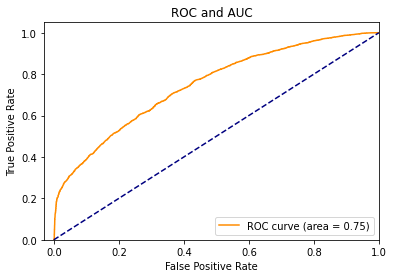

In [65]:
clf=LogisticRegression(solver='lbfgs',max_iter=300)
clf.fit(trainx, trainy)

pre_trainy=clf.predict(trainx)
proba_pre_trainy=clf.predict_proba(trainx)

fpr, tpr, thresholds=roc_curve(trainy,proba_pre_trainy[:,1],pos_label=1)
roc_auc=auc(fpr,tpr)


plt.plot(fpr, tpr, color='darkorange',label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy',  linestyle='--')
plt.xlim([-0.03, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC and AUC')
plt.legend(loc="lower right")
plt.show()

In [66]:
con_mtrx=confusion_matrix(trainy,pre_trainy,labels=[0,1])

print(classification_report(trainy,pre_trainy))

              precision    recall  f1-score   support

           0       0.76      0.92      0.83     12308
           1       0.67      0.37      0.47      5750

    accuracy                           0.74     18058
   macro avg       0.71      0.64      0.65     18058
weighted avg       0.73      0.74      0.71     18058



In [67]:
pre_testy=clf.predict(testx)
proba_pre_testy=clf.predict_proba(testx)
con_mtrx=confusion_matrix(testy,pre_testy,labels=[1,0])
accuracy=(con_mtrx[0,0]+con_mtrx[1,1])/np.sum(con_mtrx)
accuracy

0.7425064599483204

In [68]:
print(classification_report(testy,pre_testy))

              precision    recall  f1-score   support

           0       0.76      0.92      0.83      5253
           1       0.68      0.37      0.48      2487

    accuracy                           0.74      7740
   macro avg       0.72      0.64      0.65      7740
weighted avg       0.73      0.74      0.72      7740



In [69]:
x=sm.add_constant(trainx,prepend=False)
mod=sm.Logit(trainy,x).fit(method='bfgs',maxiter=100)
print(mod.summary())

Optimization terminated successfully.
         Current function value: 0.530856
         Iterations: 29
         Function evaluations: 33
         Gradient evaluations: 33
                           Logit Regression Results                           
Dep. Variable:          outcome_label   No. Observations:                18058
Model:                          Logit   Df Residuals:                    18049
Method:                           MLE   Df Model:                            8
Date:                Tue, 03 May 2022   Pseudo R-squ.:                  0.1515
Time:                        00:12:49   Log-Likelihood:                -9586.2
converged:                       True   LL-Null:                       -11298.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
sex_label             

In [114]:
import lightgbm as lgb
clf = lgb.LGBMClassifier(class_weight='balanced',drop_rate=0.9, min_data_in_leaf=100, max_bin=255,
                                 n_estimators=500,min_sum_hessian_in_leaf=1,importance_type='gain',learning_rate=0.1,bagging_fraction = 0.85,
                                 colsample_bytree = 1.0,feature_fraction = 0.1,lambda_l1 = 5.0,lambda_l2 = 3.0,max_depth =  9,
                                 min_child_samples = 55,min_child_weight = 5.0,min_split_gain = 0.1,num_leaves = 45,subsample = 0.75)  
predicts = []
clf.fit(trainx, trainy, eval_set=[(testx, testy)], early_stopping_rounds=20)
predicts.append(clf.predict(testx))

/Users/cullen/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=5.0 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] lambda_l1 is set=5.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.0
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=55 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=0.75 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] lambda_l2 is set=3.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.0
[1]	valid_0's binary_logloss: 0.681003
[2]	valid_0's binary_logloss: 0.66681
[3]	valid_0's binary_logloss: 0.652912
[4]	valid_0's binary_logloss: 0.652907
[5]	valid_0's binary_logloss: 0.646881
[6]	valid_0's binary_logloss: 0.646556
[7]	valid_0's binary_logloss: 0.646311
[8]	valid_0's binar

[257]	valid_0's binary_logloss: 0.453121
[258]	valid_0's binary_logloss: 0.45308
[259]	valid_0's binary_logloss: 0.452968
[260]	valid_0's binary_logloss: 0.452968
[261]	valid_0's binary_logloss: 0.452898
[262]	valid_0's binary_logloss: 0.452889
[263]	valid_0's binary_logloss: 0.452884
[264]	valid_0's binary_logloss: 0.452797
[265]	valid_0's binary_logloss: 0.452779
[266]	valid_0's binary_logloss: 0.452728
[267]	valid_0's binary_logloss: 0.452688
[268]	valid_0's binary_logloss: 0.452688
[269]	valid_0's binary_logloss: 0.452643
[270]	valid_0's binary_logloss: 0.452613
[271]	valid_0's binary_logloss: 0.452608
[272]	valid_0's binary_logloss: 0.452539
[273]	valid_0's binary_logloss: 0.452522
[274]	valid_0's binary_logloss: 0.452493
[275]	valid_0's binary_logloss: 0.452445
[276]	valid_0's binary_logloss: 0.452445
[277]	valid_0's binary_logloss: 0.452384
[278]	valid_0's binary_logloss: 0.452374
[279]	valid_0's binary_logloss: 0.452368
[280]	valid_0's binary_logloss: 0.452324
[281]	valid_0's b

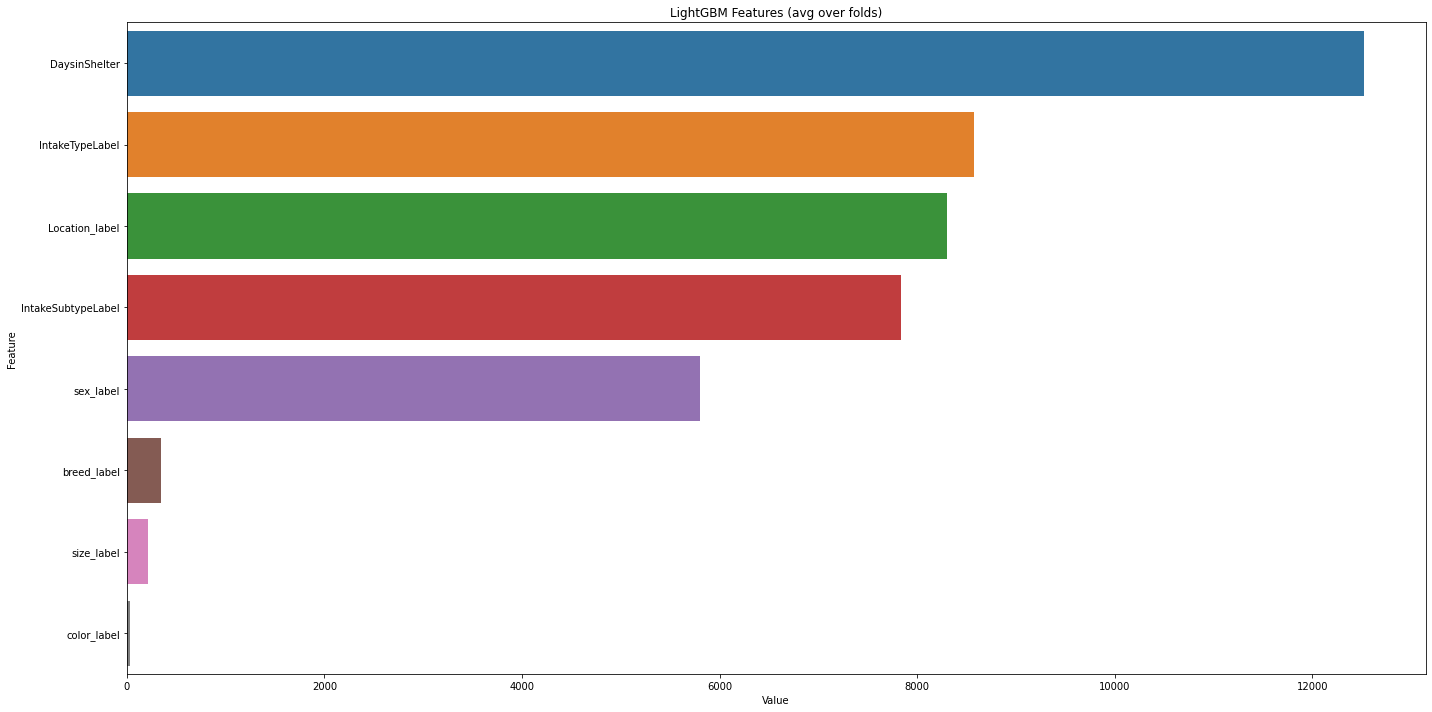

In [115]:
import seaborn as sns

feature_imp = pd.DataFrame(sorted(zip(clf.feature_importances_,smotex.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

## SMOTE

In [70]:
smotex, smotey = SMOTE(random_state=1103).fit_resample(trainx, trainy)

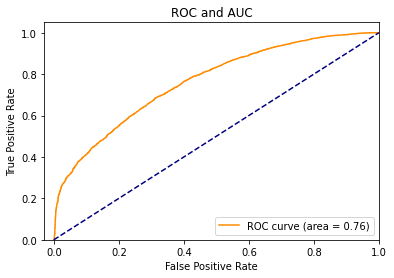

In [71]:
clf=LogisticRegression(solver='lbfgs',max_iter=300)
clf.fit(smotex, smotey)

pre_trainy=clf.predict(smotex)
proba_pre_trainy=clf.predict_proba(smotex)

fpr, tpr, thresholds=roc_curve(smotey,proba_pre_trainy[:,1],pos_label=1)
roc_auc=auc(fpr,tpr)


plt.plot(fpr, tpr, color='darkorange',label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy',  linestyle='--')
plt.xlim([-0.03, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC and AUC')
plt.legend(loc="lower right")
plt.show()

In [72]:
con_mtrx=confusion_matrix(smotey,pre_trainy,labels=[0,1])

print(classification_report(smotey,pre_trainy))

              precision    recall  f1-score   support

           0       0.68      0.71      0.69     12308
           1       0.69      0.66      0.68     12308

    accuracy                           0.68     24616
   macro avg       0.68      0.68      0.68     24616
weighted avg       0.68      0.68      0.68     24616



In [73]:
pre_testy=clf.predict(testx)
proba_pre_testy=clf.predict_proba(testx)
con_mtrx=confusion_matrix(testy,pre_testy,labels=[1,0])
accuracy=(con_mtrx[0,0]+con_mtrx[1,1])/np.sum(con_mtrx)
accuracy

0.6844961240310078

In [74]:
print(classification_report(testy,pre_testy))

              precision    recall  f1-score   support

           0       0.80      0.71      0.75      5253
           1       0.51      0.63      0.56      2487

    accuracy                           0.68      7740
   macro avg       0.66      0.67      0.66      7740
weighted avg       0.71      0.68      0.69      7740



In [75]:
x=sm.add_constant(smotex,prepend=False)
mod=sm.Logit(smotey,x).fit(method='bfgs',maxiter=100)
print(mod.summary())

Optimization terminated successfully.
         Current function value: 0.574982
         Iterations: 30
         Function evaluations: 34
         Gradient evaluations: 34
                           Logit Regression Results                           
Dep. Variable:          outcome_label   No. Observations:                24616
Model:                          Logit   Df Residuals:                    24607
Method:                           MLE   Df Model:                            8
Date:                Tue, 03 May 2022   Pseudo R-squ.:                  0.1705
Time:                        00:13:03   Log-Likelihood:                -14154.
converged:                       True   LL-Null:                       -17063.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
sex_label             

### Light GBM

In [79]:
import lightgbm as lgb
clf = lgb.LGBMClassifier(class_weight='balanced',drop_rate=0.9, min_data_in_leaf=100, max_bin=255,
                                 n_estimators=500,min_sum_hessian_in_leaf=1,importance_type='gain',learning_rate=0.1,bagging_fraction = 0.85,
                                 colsample_bytree = 1.0,feature_fraction = 0.1,lambda_l1 = 5.0,lambda_l2 = 3.0,max_depth =  9,
                                 min_child_samples = 55,min_child_weight = 5.0,min_split_gain = 0.1,num_leaves = 45,subsample = 0.75)  
predicts = []
clf.fit(smotex, smotey, eval_set=[(testx, testy)], early_stopping_rounds=20)
predicts.append(clf.predict(testx))

/Users/cullen/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=5.0 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] lambda_l1 is set=5.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.0
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=55 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=0.75 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] lambda_l2 is set=3.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.0
[1]	valid_0's binary_logloss: 0.680333
[2]	valid_0's binary_logloss: 0.665983
[3]	valid_0's binary_logloss: 0.652162
[4]	valid_0's binary_logloss: 0.65188
[5]	valid_0's binary_logloss: 0.645691
[6]	valid_0's binary_logloss: 0.645317
[7]	valid_0's binary_logloss: 0.644775
[8]	valid_0's binar

[315]	valid_0's binary_logloss: 0.443767
[316]	valid_0's binary_logloss: 0.443787
[317]	valid_0's binary_logloss: 0.443751
[318]	valid_0's binary_logloss: 0.443747
[319]	valid_0's binary_logloss: 0.44376
[320]	valid_0's binary_logloss: 0.443742
[321]	valid_0's binary_logloss: 0.443725
[322]	valid_0's binary_logloss: 0.443719
[323]	valid_0's binary_logloss: 0.443656
[324]	valid_0's binary_logloss: 0.443675
[325]	valid_0's binary_logloss: 0.44364
[326]	valid_0's binary_logloss: 0.44361
[327]	valid_0's binary_logloss: 0.443602
[328]	valid_0's binary_logloss: 0.443425
[329]	valid_0's binary_logloss: 0.443423
[330]	valid_0's binary_logloss: 0.443412
[331]	valid_0's binary_logloss: 0.443356
[332]	valid_0's binary_logloss: 0.443377
[333]	valid_0's binary_logloss: 0.443349
[334]	valid_0's binary_logloss: 0.443344
[335]	valid_0's binary_logloss: 0.443338
[336]	valid_0's binary_logloss: 0.443083
[337]	valid_0's binary_logloss: 0.443097
[338]	valid_0's binary_logloss: 0.443096
[339]	valid_0's bin

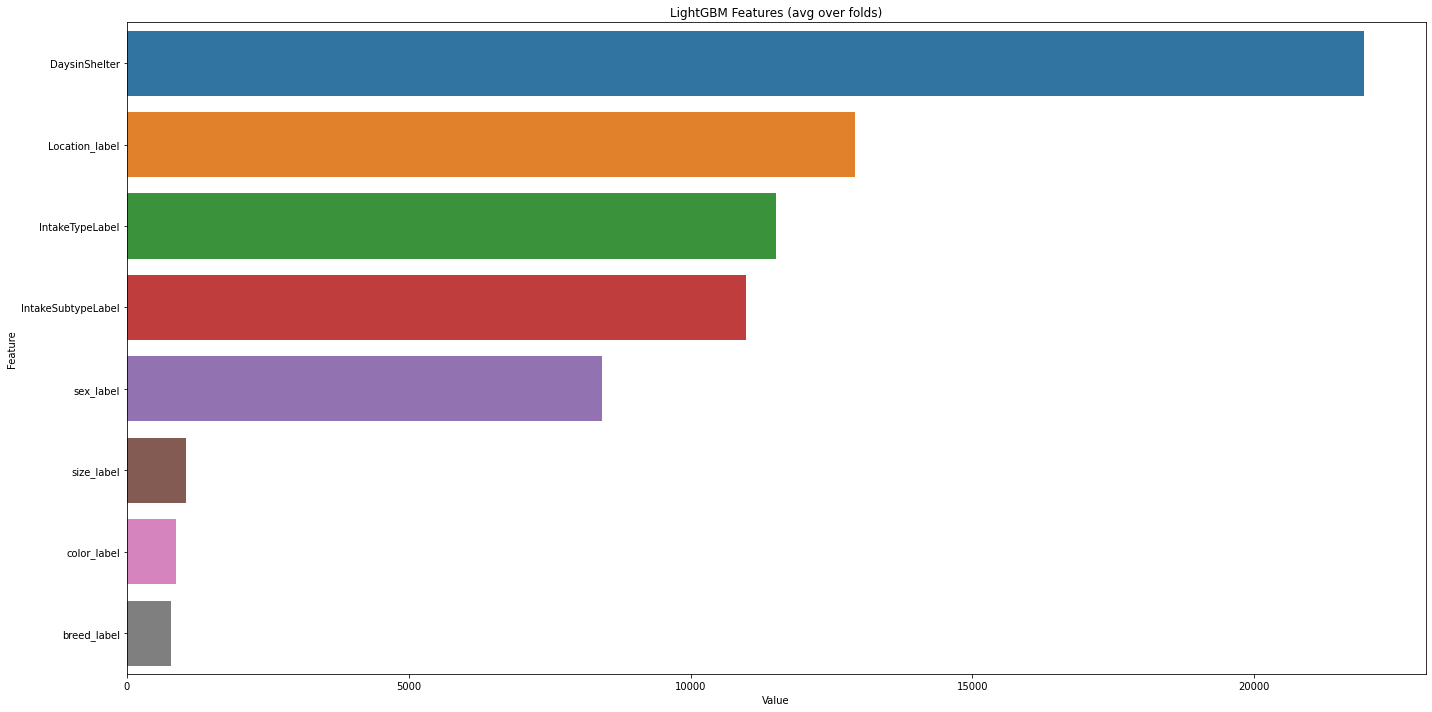

In [80]:
import seaborn as sns

feature_imp = pd.DataFrame(sorted(zip(clf.feature_importances_,smotex.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

### Caculate the sensitive measure based on the prediction of Logistic regression

In [76]:
def stat_parity2(preds, sens):
    '''
    :preds: numpy array of the model predictions. Consisting of 0s and 1s
    :sens: numpy array of the sensitive features. Consisting of 0s and 1s
    :return: the statistical parity. no need to take the absolute value
    '''
    group1=0
    group2=0
    count1=0
    count2=0
    for i in range(len(sens)):
        if sens[i]==1:
            group1+=1
            if preds[i]==1:
                count1+=1
        else:
            group2+=1
            if preds[i]==1:
                count2+=1
    prob1=count1/group1 if group1!=0 else 0
    prob2=count2/group2 if group2!=0 else 0
    return prob1-prob2


def eq_oppo2(preds, sens, labels):
    '''
    :preds: numpy array of the model predictions. Consisting of 0s and 1s
    :sens: numpy array of the sensitive features. Consisting of 0s and 1s
    :labels: numpy array of the ground truth labels of the outcome. Consisting of 0s and 1s
    :return: the statistical parity. no need to take the absolute value
    '''
    
    group1=0
    group2=0
    count1=0
    count2=0
    for i in range(len(sens)):
        if (sens[i]==1) and (labels[i]==1):
            group1+=1
            if preds[i]==1:
                count1+=1
        elif (sens[i]==0) and (labels[i]==1):
            group2+=1
            if preds[i]==1:
                count2+=1
    prob1=count1/group1 if group1!=0 else 0
    prob2=count2/group2 if group2!=0 else 0
    return prob1-prob2

In [77]:
testx=testx.reset_index(drop=True)
testy=testy.reset_index(drop=True)

In [78]:
stat_p = stat_parity2(pre_testy, testx['color_label'])
eq_op = eq_oppo2(pre_testy, testx['color_label'], testy)
print( stat_p, eq_op)

-0.19167651765535487 -0.2116912128553572


### SVM using grid search cv

In [83]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
import numpy as np
C_range = np.logspace(-1, 1, 3)
gamma_range = np.linspace(0.1, 1, 5)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedKFold(10, random_state=1, shuffle=True)
def choosemodel(classifier, x_train, y_train, x_test, y_test,param_grid,cv):
    model = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=cv)
    model.fit(x_train, y_train)
    prediction = model.predict(x_test)
    print("The parameter we choose for this SVM model is:")
    print(model.best_params_, "\n")
    print(classification_report(y_test, prediction))
    return model

In [84]:
result= choosemodel(SVC(kernel='rbf'),trainx, trainy, testx, testy,param_grid,cv)

The parameter we choose for this SVM model is:
{'C': 10.0, 'gamma': 0.1} 

              precision    recall  f1-score   support

           0       0.82      0.91      0.86      5253
           1       0.76      0.57      0.65      2487

    accuracy                           0.80      7740
   macro avg       0.79      0.74      0.76      7740
weighted avg       0.80      0.80      0.79      7740



In [86]:
svm_prediction = result.predict(testx)
svm_stat_p = stat_parity2(svm_prediction, testx['color_label'])
svm_eq_op = eq_oppo2(svm_prediction, testx['color_label'], testy)
print( svm_stat_p, svm_eq_op)

-0.0028448404103318115 -0.019156181263282557


# remove color

In [90]:
nocolor_trainx=trainx.drop(columns=['color_label'])
nocolor_testx=testx.drop(columns=['color_label'])

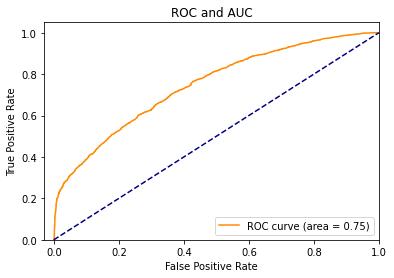

In [91]:
nocolor_clf=LogisticRegression(solver='lbfgs',max_iter=300)
nocolor_clf.fit(nocolor_trainx, trainy)

nocolor_pre_trainy=nocolor_clf.predict(nocolor_trainx)
nocolor_proba_pre_trainy=nocolor_clf.predict_proba(nocolor_trainx)

fpr, tpr, thresholds=roc_curve(trainy,nocolor_proba_pre_trainy[:,1],pos_label=1)
roc_auc=auc(fpr,tpr)


plt.plot(fpr, tpr, color='darkorange',label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy',  linestyle='--')
plt.xlim([-0.03, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC and AUC')
plt.legend(loc="lower right")
plt.show()

In [92]:
con_mtrx=confusion_matrix(trainy,nocolor_pre_trainy,labels=[0,1])

print(classification_report(trainy,nocolor_pre_trainy))

              precision    recall  f1-score   support

           0       0.76      0.91      0.83     12308
           1       0.66      0.37      0.47      5750

    accuracy                           0.74     18058
   macro avg       0.71      0.64      0.65     18058
weighted avg       0.73      0.74      0.71     18058



In [93]:
nocolor_pre_testy=nocolor_clf.predict(nocolor_testx)
nocolor_proba_pre_testy=nocolor_clf.predict_proba(nocolor_testx)
con_mtrx=confusion_matrix(testy,nocolor_pre_testy,labels=[1,0])
accuracy=(con_mtrx[0,0]+con_mtrx[1,1])/np.sum(con_mtrx)
accuracy

0.7410852713178294

In [94]:
con_mtrx=confusion_matrix(testy,nocolor_pre_testy,labels=[0,1])

print(classification_report(testy,nocolor_pre_testy))

              precision    recall  f1-score   support

           0       0.76      0.92      0.83      5253
           1       0.68      0.37      0.48      2487

    accuracy                           0.74      7740
   macro avg       0.72      0.64      0.65      7740
weighted avg       0.73      0.74      0.72      7740



In [95]:
stat_p = stat_parity2(nocolor_pre_testy, testx['color_label'])
eq_op = eq_oppo2(nocolor_pre_testy, testx['color_label'], testy)
print( stat_p, eq_op)

-0.039859241196239514 -0.08274434875133363


### SVM using no color column

In [98]:
no_color_result= choosemodel(SVC(kernel='rbf'),nocolor_trainx, trainy, nocolor_testx, testy,param_grid,cv)

The parameter we choose for this SVM model is:
{'C': 10.0, 'gamma': 0.1} 

              precision    recall  f1-score   support

           0       0.82      0.91      0.86      5253
           1       0.76      0.57      0.65      2487

    accuracy                           0.80      7740
   macro avg       0.79      0.74      0.76      7740
weighted avg       0.80      0.80      0.80      7740



In [101]:
svm_prediction = no_color_result.predict(nocolor_testx)
svm_stat_p = stat_parity2(svm_prediction, testx['color_label'])
svm_eq_op = eq_oppo2(svm_prediction, testx['color_label'], testy)
print( svm_stat_p, svm_eq_op)

-0.003906534413294305 -0.024555723042335442


# remove size

In [102]:
def stat_parity3(preds, sens):
    '''
    :preds: numpy array of the model predictions. Consisting of 0s and 1s
    :sens: numpy array of the sensitive features. Consisting of 0s and 1s
    :return: the statistical parity. no need to take the absolute value
    '''
    group1=0
    group2=0
    group3=0
    count1=0
    count2=0
    count3=0
    for i in range(len(sens)):
        if sens[i]==0:
            group1+=1
            if preds[i]==1:
                count1+=1
        elif sens[i]==1:
            group2+=1
            if preds[i]==1:
                count2+=1
        else:
            group3+=1
            if preds[i]==1:
                count3+=1
    prob1=count1/group1 if group1!=0 else 0
    prob2=count2/group2 if group2!=0 else 0
    prob3=count3/group3 if group3!=0 else 0
    return np.var([prob1,prob2,prob3])


def eq_oppo3(preds, sens, labels):
    '''
    :preds: numpy array of the model predictions. Consisting of 0s and 1s
    :sens: numpy array of the sensitive features. Consisting of 0s and 1s
    :labels: numpy array of the ground truth labels of the outcome. Consisting of 0s and 1s
    :return: the statistical parity. no need to take the absolute value
    '''
    
    group1=0
    group2=0
    group3=0
    count1=0
    count2=0
    count3=0
    for i in range(len(sens)):
        if (sens[i]==0) and (labels[i]==1):
            group1+=1
            if preds[i]==1:
                count1+=1
        elif (sens[i]==1) and (labels[i]==1):
            group2+=1
            if preds[i]==1:
                count2+=1
        elif (sens[i]==2) and (labels[i]==1):
            group3+=1
            if preds[i]==1:
                count3+=1
    prob1=count1/group1 if group1!=0 else 0
    prob2=count2/group2 if group2!=0 else 0
    prob3=count3/group3 if group3!=0 else 0
    return np.var([prob1,prob2,prob3])


In [103]:
stat_p = stat_parity3(pre_testy, testx['size_label'])
eq_op = eq_oppo3(pre_testy, testx['size_label'], testy)
print( stat_p, eq_op)

0.006621581161820333 0.010087162053455598


In [104]:
nosize_trainx=trainx.drop(columns=['size_label'])
nosize_testx=testx.drop(columns=['size_label'])

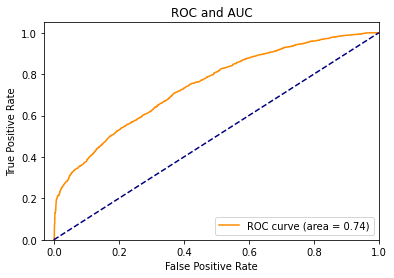

In [105]:
nosize_clf=LogisticRegression(solver='lbfgs',max_iter=300)
nosize_clf.fit(nosize_trainx, trainy)

nosize_pre_trainy=nosize_clf.predict(nosize_trainx)
proba_nosize_pre_trainy=nosize_clf.predict_proba(nosize_trainx)

fpr, tpr, thresholds=roc_curve(trainy,proba_nosize_pre_trainy[:,1],pos_label=1)
roc_auc=auc(fpr,tpr)


plt.plot(fpr, tpr, color='darkorange',label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy',  linestyle='--')
plt.xlim([-0.03, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC and AUC')
plt.legend(loc="lower right")
plt.show()

In [107]:
#con_mtrx=confusion_matrix(trainy,nosize_pre_trainy,labels=[0,1])
nosize_pre_testy=nosize_clf.predict(nosize_testx)
print(classification_report(testy,nosize_pre_testy))

              precision    recall  f1-score   support

           0       0.75      0.91      0.82      5253
           1       0.66      0.37      0.48      2487

    accuracy                           0.74      7740
   macro avg       0.71      0.64      0.65      7740
weighted avg       0.72      0.74      0.71      7740



In [108]:
nosize_pre_testy=nosize_clf.predict(nosize_testx)
nosize_proba_pre_testy=nosize_clf.predict_proba(nosize_testx)
con_mtrx=confusion_matrix(testy,nosize_pre_testy,labels=[1,0])
accuracy=(con_mtrx[0,0]+con_mtrx[1,1])/np.sum(con_mtrx)
accuracy

0.7366925064599483

In [109]:
stat_p = stat_parity3(nosize_pre_testy, testx['size_label'])
eq_op = eq_oppo3(nosize_pre_testy, testx['size_label'], testy)
print( stat_p, eq_op)

2.8729893975769922e-05 0.0012308579297140541


In [110]:
no_size_result= choosemodel(SVC(kernel='rbf'),nosize_trainx, trainy, nosize_testx, testy,param_grid,cv)

The parameter we choose for this SVM model is:
{'C': 10.0, 'gamma': 0.1} 

              precision    recall  f1-score   support

           0       0.82      0.91      0.86      5253
           1       0.76      0.56      0.65      2487

    accuracy                           0.80      7740
   macro avg       0.79      0.74      0.75      7740
weighted avg       0.80      0.80      0.79      7740



In [111]:
svm_prediction = no_size_result.predict(nosize_testx)
svm_stat_p = stat_parity3(svm_prediction, testx['size_label'])
svm_eq_op = eq_oppo3(svm_prediction, testx['size_label'], testy)
print( svm_stat_p, svm_eq_op)

0.0003571009878177921 0.00018220758858951167
